In [0]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dataset
import torchvision.transforms as transforms
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
!pip install PyDrive

In [0]:

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once in a notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [6]:
drive

In [0]:
def loadData(BS = 1):
    path = "drive/My Drive/recyclerDataset"
    
    transform = transforms.Compose([transforms.ToTensor()])
    
    trainset = dataset.ImageFolder(path + "/train/", transform = transform)
    validset = dataset.ImageFolder(path + "/validation/", transform = transform)
    train_loader = torch.utils.data.DataLoader(trainset, batch_size = BS, shuffle = "true")
    valid_loader = torch.utils.data.DataLoader(validset, batch_size = BS, shuffle = "true")
    return train_loader, valid_loader, trainset

In [30]:
trainset

Dataset ImageFolder
    Number of datapoints: 2392
    Root location: drive/My Drive/recyclerDataset/train/
    StandardTransform
Transform: Compose(
               ToTensor()
           )

In [0]:
train_loader, valid_loader, trainset = loadData()

In [39]:
train_loader

<class 'torch.Tensor'>
torch.Size([384, 512, 3])
label:  tensor([2])
<class 'torch.Tensor'>
torch.Size([384, 512, 3])
label:  tensor([2])
<class 'torch.Tensor'>
torch.Size([384, 512, 3])
label:  tensor([3])
<class 'torch.Tensor'>
torch.Size([384, 512, 3])
label:  tensor([1])


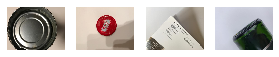

In [42]:
k=0
for data, label in train_loader:
    image = data[0]
    print(type(image))
    img = np.transpose(image, [1,2,0])
    print(img.shape)
    print("label: ", label)
    plt.subplot(3, 5, k+1)
    plt.axis('off')
    plt.imshow(img)
    
    k+=1
    if k > 3:
        break

In [0]:
class recycler(nn.Module):
    def __init__(self):
        super(recycler, self).__init__()
        self.name = "recycler"
        self.conv1 = nn.Conv2d(3, 5, 5)
        self.conv2 = nn.Conv2d(5, 7, 5)
        self.conv3 = nn.Conv2d(7, 5, 3)
        self.pool1 = nn.MaxPool2d(4, 4)
        self.pool2 = nn.MaxPool2d(2, 2)
        #self.fc1 = nn.Linear(7130, 1024)
        self.fc2 = nn.Linear(700, 6)
        #self.fc3 = nn.Linear(512, 6)
    
    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool1(F.relu(self.conv2(x)))
        x = self.pool2(F.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        #x = F.relu(self.fc1(x))
        x = self.fc2(x)
        #x = self.fc3(x)
        x = x.squeeze(1)
        return x

In [0]:
model = recycler()

In [0]:
def train(net, batch_size=1, learning_rate=0.001, num_epochs=30):
    train_loader, valid_loader = loadData(BS = batch_size)
    
    loss_func = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr = learning_rate)
    
    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    train_acc = np.zeros(num_epochs)
    
    valid_err = np.zeros(num_epochs)
    valid_loss = np.zeros(num_epochs)
    valid_acc = np.zeros(num_epochs)
    
    
    for epoch in range(num_epochs):
        total_train_loss = 0.0
        total_train_err = 0.0
        total_train_acc = 0.0
        total_num = 0
        
        for i, data in enumerate(train_loader, 0):
            image, label = data
            optimizer.zero_grad()
            
            train_output = net(image.view(-1, 3, 384, 512))
            loss = loss_func(train_output, label)
            total_train_loss += loss.item()
            
            train_output = F.softmax(train_output, dim = 1)
            prediction, idx = torch.max(train_output, 1)
            
            if batch_size is 1:
                corr = 0
                if(torch.equal(idx, label)):
                    corr = 1
                
                total_train_err += batch_size - corr
                total_train_acc += corr
            
            else:
                corr = torch.eq(idx, label).sum().item()
                total_train_err += image.shape[0] - corr
                total_train_acc += corr

            total_num += image.shape[0]
            loss.backward()
            optimizer.step()
        
        train_loss[epoch] = float(total_train_loss) / (i+1)
        train_err[epoch] = float(total_train_err) / total_num
        train_acc[epoch] = float(total_train_acc) / total_num
        
        valid_loss[epoch], valid_err[epoch], valid_acc[epoch] = evaluate(net, valid_loader, loss_func, batch_size)
        print( ("epoch: {}  train loss: {}  train error {}  train accuracy: {} ").format(epoch+1, train_err[epoch], train_loss[epoch], train_acc[epoch]))
        print( ("epoch: {}  valid loss: {}  valid error {}  valid accuracy: {} ").format(epoch+1, valid_err[epoch], valid_loss[epoch], valid_acc[epoch]))
    
    return train_loss, train_err, train_acc, valid_loss, valid_err, valid_acc

In [0]:
def evaluate(net, loader, loss_func, batch_size):
    total_loss = 0.0
    total_err = 0.0
    total_acc = 0.0
    total_num = 0

    for i, data in enumerate(loader, 0):
        inputs, labels = data

        outputs = net(inputs)
        loss = loss_func(outputs, labels)
        total_loss += loss.item()

        outputs = F.softmax(outputs, dim = 1)
        prediction, idx = torch.max(outputs, 1)

        if batch_size is 1:
            corr = 0
            if(torch.equal(idx, labels)):
              corr = 1
            total_err += batch_size - corr
            total_acc += corr
          
        else:
            corr = torch.eq(idx, labels).sum().item()
            total_err += inputs.shape[0] - corr
            total_acc += corr
          
        total_num += inputs.shape[0]
    
    error = total_err/total_num
    loss = total_loss/(i+1)
    accuarcy = total_acc/total_num
    return loss, error, accuarcy


In [60]:
train_loss, train_err, train_acc, valid_loss, valid_err, valid_acc = train(model, batch_size=16, learning_rate=0.005, num_epochs=30)

path = "drive/My Drive/recyclerDataset/TrainedModel/recycler.pt" 
torch.save(model.state_dict(), path)


train_acc_df = pd.DataFrame(train_acc)
train_acc_df.to_csv("drive/My Drive/recyclerDataset/accuracy/train_acc.csv")

valid_acc_df = pd.DataFrame(valid_acc)
valid_acc_df.to_csv("drive/My Drive/recyclerDataset/accuracy/valid_acc.csv")

epoch: 1  train loss: 0.38377926421404684  train error 1.0463914293050767  train accuracy: 0.6162207357859532 
epoch: 1  valid loss: 0.7777777777777778  valid error 3.2008021672566733  valid accuracy: 0.2222222222222222 
epoch: 2  train loss: 0.38001672240802675  train error 0.9929388741652171  train accuracy: 0.6199832775919732 
epoch: 2  valid loss: 0.8296296296296296  valid error 2.9781959321763782  valid accuracy: 0.17037037037037037 
epoch: 3  train loss: 0.33695652173913043  train error 0.9519386692841848  train accuracy: 0.6630434782608695 
epoch: 3  valid loss: 0.8296296296296296  valid error 3.1752273771497936  valid accuracy: 0.17037037037037037 
epoch: 4  train loss: 0.3632943143812709  train error 0.9679571479558945  train accuracy: 0.6367056856187291 
epoch: 4  valid loss: 0.7851851851851852  valid error 3.251871029535929  valid accuracy: 0.21481481481481482 
epoch: 5  train loss: 0.32148829431438125  train error 0.876426999370257  train accuracy: 0.6785117056856187 
epoch

torch.Size([384, 512, 3])
label:  tensor([1])
prediction:  tensor([1])


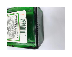

In [77]:
for data, label in train_loader:
    image = data[0]
    img = np.transpose(image, [1,2,0])
    print(img.shape)
    print("label: ", label)
    plt.subplot(3, 5, k+1)
    plt.axis('off')
    plt.imshow(img)

    output = model(data)
    output = F.softmax(output, dim = 1)
    prediction, idx = torch.max(output, 1)

    print("prediction: ", idx)
    break


In [0]:
def takeImage(image):
    trans = transforms.ToTensor()
    image = trans(image)
    model.load_state_dict(torch.load("drive/My Drive/recyclerDataset/Archive/3. 85% accuracy/recycler.pt"))
    output = model(image.view(-1, 3, 384, 512))
    output = F.softmax(output, dim = 1)
    prediction, idx = torch.max(output, 1)
    
    idxToClass = dict({0:'Cardboard',1:'Glass',2:'Metal', 3:'Paper', 4:'Plastic', 5:'Trash'})
    #have a dict for idx to category
    return idxToClass[int(idx)]

In [31]:
from PIL import Image
jpgfile = Image.open("drive/My Drive/recyclerDataset/train/cardboard/cardboard1.jpg")
 
print(jpgfile.bits, jpgfile.size, jpgfile.format)
print(type(jpgfile))

8 (512, 384) JPEG
<class 'PIL.JpegImagePlugin.JpegImageFile'>
